## Predicting Superstore Sales

### Problem Definition

Working with global Superstore sales data that was collected for 4 years (2015-2019), time series analysis will be conducted to predict its future sales trend.

    Author: Андреј Атанасовски
    Date: 30-08-2022

### Import Libraries

In [1]:
import pandas as pd
import datetime
import numpy as  np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn  import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score, roc_auc_score
import statsmodels.api as sm

import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [2]:
# load data
DATA = "train.csv"

# Load data
df = pd.read_csv(DATA, parse_dates=['Order Date'])

### Summary of Dataset

In [3]:
# Show all columns.
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9800 non-null   int64         
 1   Order ID       9800 non-null   object        
 2   Order Date     9800 non-null   datetime64[ns]
 3   Ship Date      9800 non-null   object        
 4   Ship Mode      9800 non-null   object        
 5   Customer ID    9800 non-null   object        
 6   Customer Name  9800 non-null   object        
 7   Segment        9800 non-null   object        
 8   Country        9800 non-null   object        
 9   City           9800 non-null   object        
 10  State          9800 non-null   object        
 11  Postal Code    9789 non-null   float64       
 12  Region         9800 non-null   object        
 13  Product ID     9800 non-null   object        
 14  Category       9800 non-null   object        
 15  Sub-Category   9800 n

First quick look of data shows it is a nice and clean data with with 9800 rows and 18 columns. Each entry shows details of customer orders along with the total cost (Sales) they have paid.

### Aggregating Daily Sales

Right now, our data is showing all the individual orders made by customers. In other words, there are many duplicates of the same order date. To be able to compare sales over time, we need to know the daily total of the sales. Let’s sum all sales that were made on the same day.

- Еден податок од датасетот е за еден индивидуален ордер направен од некој купувач, така што на една иста дата може да има повеќе ордери направени. Ние се фокусираме на тоа да предвидиме продажба со текот на времето, затоа ни треба да знаеме вкупен број на дневно направени продажби. И заради тоа ги сумираме сите продажби кои се направени на ист ден.

In [4]:
# aggregate all entries with the same order date
dfDailySales = pd.DataFrame(df.groupby('Order Date')['Sales'].sum())

dfDailySales

,Sales
Order Date,
2015-01-02,468.9000
2015-01-03,2203.1510
2015-01-04,119.8880
2015-01-06,5188.5200
2015-01-07,601.0240
...,...
2018-12-26,814.5940
2018-12-27,177.6360
2018-12-28,1657.3508


Now we have nice time series data to work with.


### Best Selling Products

In this section, we will look into some popular products that are frequently bought by customers. In other words, these are the products that contributed the most to generate sales day to day.


### Top Sub-Categories by Number of Sales

Below is a list of sub-categories sorted by the number of sales in descending order. Stationary item such as binders and papers the top 2, followed by furnishings, phones, storage and art.


In [5]:
bestCategory = df['Sub-Category'].value_counts()
bestCategory

Binders        1492
Paper          1338
Furnishings     931
Phones          876
Storage         832
Art             785
Accessories     756
Chairs          607
Appliances      459
Labels          357
Tables          314
Envelopes       248
Bookcases       226
Fasteners       214
Supplies        184
Machines        115
Copiers          66
Name: Sub-Category, dtype: int64

### Top Sub-Categories by Amount of Sales

Best selling categories does not necessarily mean they generated the most profit. Some sub-categories may contain high-end, costly items that sums up to account for the highest amount of sales.


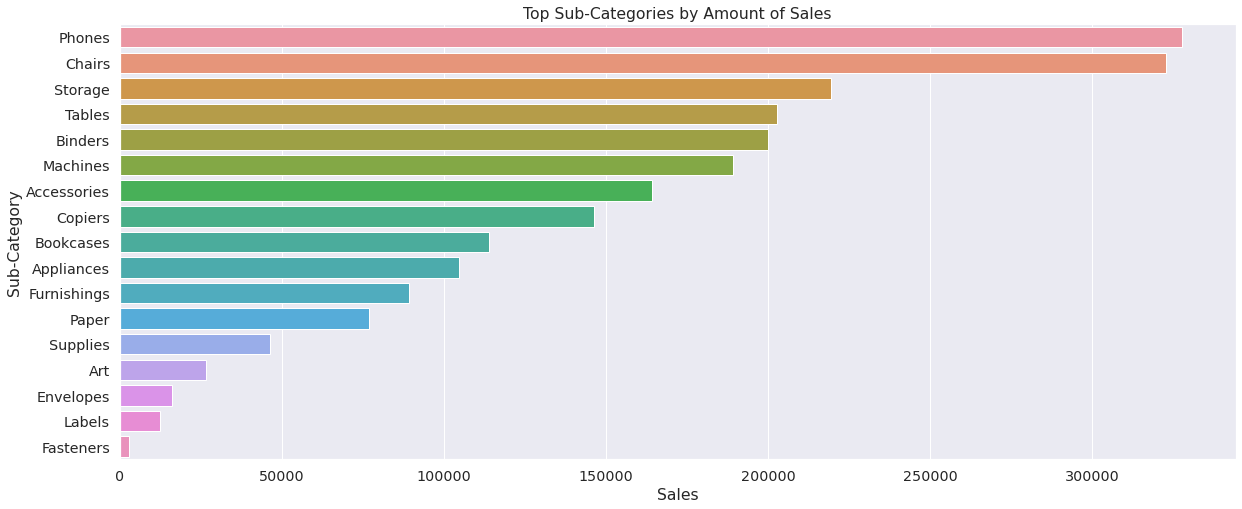

In [6]:
highestCategory = df.groupby(df["Sub-Category"]).sum()['Sales'].reset_index()
highestCategory = highestCategory.sort_values("Sales", ascending = False)

sns.set(font_scale=1.3)
plt.figure(figsize=(20,8));
plt.title('Top Sub-Categories by Amount of Sales')
sns.set_style('darkgrid')
sns.barplot(x='Sales', y='Sub-Category',data = highestCategory);

Although Binders was the top-selling sub-category, it is ranked at 5th in the top highest amount of sales sub-categories. Instead, expensive electronics such as Phones is ranked as the first in the list, followed by bigger furnitures like chairs, storgae and tables.


### Customer Profile

Next, we are going to see if there are any common characteristics of Superstore's regular shoppers.

### Top 25 Cities by Number of Sales

The data only contains order information recorded from the United States. These are top 25 American cities that have placed the highest numbers of orders.


In [7]:
bestCity = df['City'].value_counts().head(25)
bestCity

New York City    891
Los Angeles      728
Philadelphia     532
San Francisco    500
Seattle          426
Houston          374
Chicago          308
Columbus         221
San Diego        170
Springfield      161
Dallas           156
Jacksonville     125
Detroit          115
Newark            92
Jackson           82
Columbia          81
Richmond          81
Aurora            68
Phoenix           63
Arlington         60
San Antonio       59
Miami             56
Louisville        54
Rochester         53
Long Beach        52
Name: City, dtype: int64

Big cities like New York City, Los angeles, Philadelphia, San Francisco and Seattle are ranked at the first 5.

### Top 25 Cities by Amount of Sales

Here are top 25 cities that have generated the highest amount of sales.


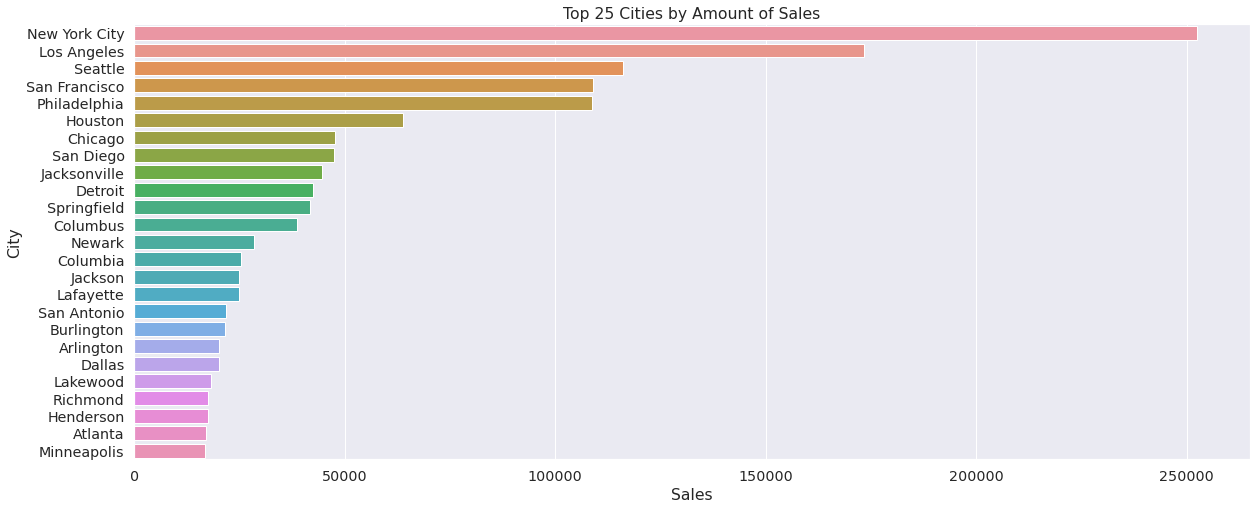

In [8]:
highestCities = pd.DataFrame(df.groupby(df['City']).sum()['Sales']).reset_index()
highestCities = highestCities.sort_values("Sales", ascending = False)

sns.set(font_scale=1.3)
plt.figure(figsize=(20,8));
plt.title('Top 25 Cities by Amount of Sales')
sns.set_style('darkgrid')
sns.barplot(x='Sales', y='City',data = highestCities.head(25));

Unlike the top Sub-Categories, top 5 cities with the highest number of sales are the same as the cities with the highest amount of sales.

Customers in New York City has spent noticeably large money on Superstore. They spent about twice more than Seattle, which is still ranked at 3rd.

### Time Series Decomposition

Time series data often exhibit trend, cyclic and seasonal behaviour. To find such patterns, it is always a good idea to have a visual representation. See the graph below that shows the monthly sales trends of Superstore.


/tmp/ipykernel_4216/3662433916.py:3: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  dfDailySales['Sales'].resample("M", loffset="1D").sum().plot(label='Monthly Sales')


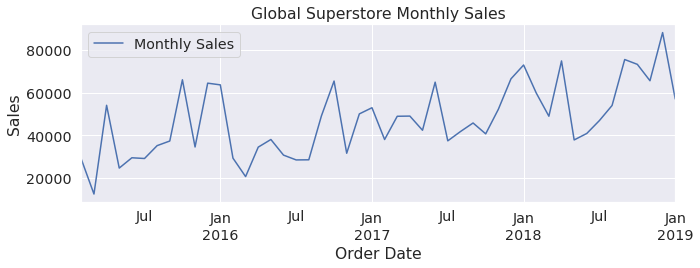

In [9]:
# resample data with the sum of monthly sales
plt.figure(figsize=(10, 4))
dfDailySales['Sales'].resample("M", loffset="1D").sum().plot(label='Monthly Sales')

plt.title("Global Superstore Monthly Sales")
plt.legend(loc="best")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()



It is not very strong, but our data has a positive trend. Sales have been slowly increasing over the last 4 years. There are some seasonality observed from big peaks around December (probability for a lot of holiday shoppings) and troughs around July, forming a rough "W" shape presenting every year. It is not very clear if our data has cycles.

The seasonality is even more apparent when data is decomposed. See the visualization below.


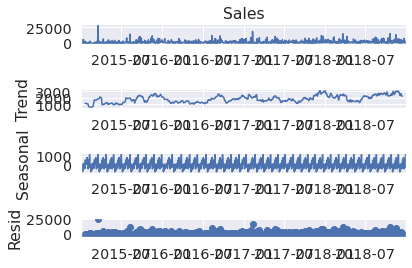

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform decomposition using multiplicative decomposition.
tseries = seasonal_decompose(dfDailySales['Sales'], model='additive', period=30)

tseries.plot()
plt.tight_layout()
plt.show()

In [11]:
##################################################################
NUM_TIME_STEPS  = 60
TEST_DAYS       = 30    # for test and validation
EVAL_DAYS       = 1    # 15 for testing and the other 15 for validation for the stacked model.
##################################################################

### Least Sqares Regression

First modell is a simple least square regression.

### Backshifting

For the OLS model, we are shifting columns to create time steps that will be used as predictor variables.


In [12]:
# Creates time shifted columns for as many time steps needed.
def backShiftColumns(df, originalColName, numTimeSteps):
    dfNew  = df[[originalColName]]

    for i in range(1, numTimeSteps + 1):
        newColName       = originalColName[0] + 't-' + str(i)
        dfNew[newColName]= dfNew[originalColName].shift(periods=i)
    return dfNew

def prepareDf(df, columns):

    # Create data frame with back shift columns for all features of interest.
    mergedDf = pd.DataFrame()
    for i in range(0, len(columns)):
        backShiftedDf  = backShiftColumns(df, columns[i], NUM_TIME_STEPS)
        if(i==0):
            mergedDf = backShiftedDf
        else:
            mergedDf = mergedDf.merge(backShiftedDf, left_index=True,
                       right_index=True)

    return mergedDf

In [13]:
columns = ["Sales"]
dfSales = prepareDf(dfDailySales, columns)
dfSales.dropna(inplace=True)

In [14]:
sigFeaturesLi = ["St-25", "St-33", "St-46", "St-60"]

# Split X and y
X = dfSales.copy()
X = X[sigFeaturesLi]
y = dfSales["Sales"]

# Add intercept for OLS regression.
X = sm.add_constant(X)

### Splitting Test and Train sets

In [15]:
# Split into test and train sets. The test data must be the latest data range.
lenData = len(X)
X_train = X[0:lenData-TEST_DAYS]
y_train = y[0:lenData-TEST_DAYS]
X_test  = X[lenData-TEST_DAYS:lenData-EVAL_DAYS]    # 15 for testing
y_test  = y[lenData-TEST_DAYS:lenData-EVAL_DAYS]
stack_X_test = X[lenData-EVAL_DAYS:]        # 15 for stacked evaluation
stack_y_test = y[lenData-EVAL_DAYS:]

### Fitting the Model

In [16]:
# Fit the model
olsModel = sm.OLS(endog=y_train, exog=X_train).fit()

## SARIMA

SARIMA or Seasonal ARIMA stand for Seasonal Autoregressive Integrated Moving Average. Since our model has seasonality influence, SARIMAX will be used to build an ARIMAX model.


### SARIMA - се користи кога има сезонски елемент, во датасетот. Поточно кога гледаме дека зависи од тоа која сезона во годината е.

### Seasonal Differencing

This section shows the visual representation of outcomes of different techniques to treat seasonal patterns.


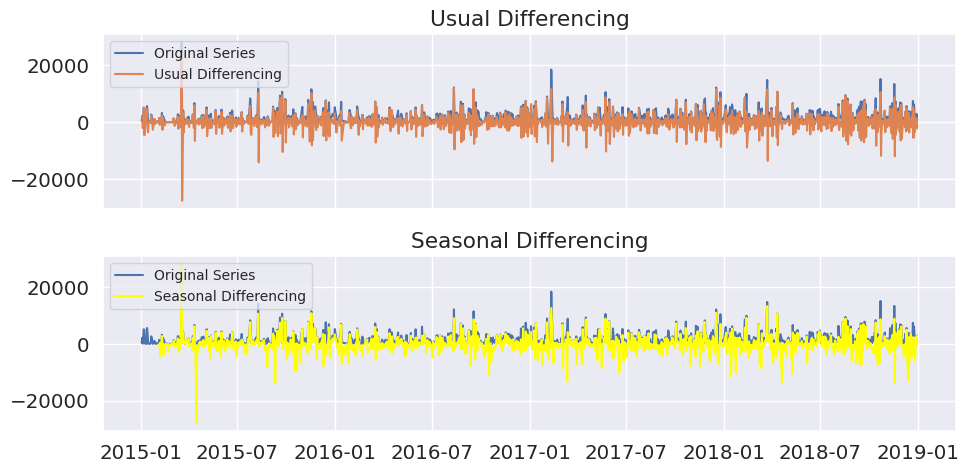

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(dfDailySales[:], label='Original Series')
axes[0].plot(dfDailySales[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)

# Seasonal Differencing
axes[1].plot(dfDailySales[:], label='Original Series')
axes[1].plot(dfDailySales[:].diff(24), label='Seasonal Differencing', color='yellow')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

Unfortunately, it is hard to see differences between the usual differencing and seasonal differencing from our data perhaps because the upward trend was so weak in the data.

### ACF & PACF Plots

First thing we can do is to plot an ACF and PACF of our data so othat we could get an idea of what order we should use for SARIMA.


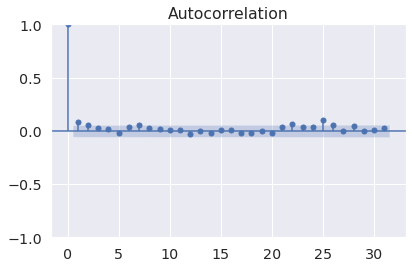

/home/user/miniconda3/envs/AI/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


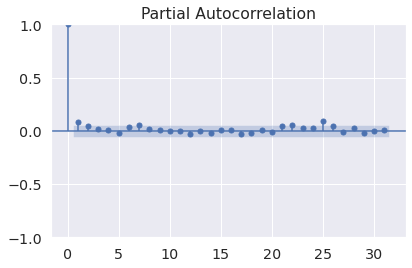

In [18]:
plot_acf(dfDailySales['Sales'])
plt.tight_layout()
plt.show()
plot_pacf(dfDailySales['Sales'])
plt.tight_layout()
plt.show()

ACF and PACF are showing a very similar behaviour. We can see in both ACF and PACF that there is no noticeable lag, but maybe slightly at 6 and 25.

### Building SARIMA Model

I have used auto_arima function from pmdarima library to auto build the most optimized SARIMA model based on its AIC value.

## Auto-ARIMA

In [19]:
lenData = len(dfDailySales)
dfTrain = dfDailySales[0:lenData-TEST_DAYS]
dfTest = dfDailySales[lenData-TEST_DAYS:lenData-EVAL_DAYS]

In [20]:
sarimaModel = pm.auto_arima(dfTrain, start_p=1, start_q=1,
                         test='adf',
                         max_p=1, max_q=1, m=25,
                         start_P=1, start_Q= 1, seasonal=True, 
                         max_P=1, max_Q=1,
                         d=1, D=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[25]             : AIC=inf, Time=14.62 sec
 ARIMA(0,1,0)(0,1,0)[25]             : AIC=22948.890, Time=0.18 sec
 ARIMA(1,1,0)(1,1,0)[25]             : AIC=22339.569, Time=1.47 sec
 ARIMA(0,1,1)(0,1,1)[25]             : AIC=inf, Time=6.08 sec
 ARIMA(1,1,0)(0,1,0)[25]             : AIC=22623.701, Time=0.24 sec
 ARIMA(1,1,0)(1,1,1)[25]             : AIC=inf, Time=7.64 sec
 ARIMA(1,1,0)(0,1,1)[25]             : AIC=inf, Time=5.48 sec
 ARIMA(0,1,0)(1,1,0)[25]             : AIC=22612.816, Time=1.53 sec
 ARIMA(1,1,1)(1,1,0)[25]             : AIC=inf, Time=7.14 sec
 ARIMA(0,1,1)(1,1,0)[25]             : AIC=inf, Time=5.25 sec
 ARIMA(1,1,0)(1,1,0)[25] intercept   : AIC=22341.567, Time=2.02 sec

Best model:  ARIMA(1,1,0)(1,1,0)[25]          
Total fit time: 51.659 seconds


### SARIMAX(1, 1, 0)x(1, 1, 0, 25) has been chosen as the best model. It has AIC value of 22339.569, and all p-values are significant. With the determined SARIMAX order values, now we can fit the model.


### Fitting the Model


In [21]:
order=(1, 1, 0)
seasonalOrder = (1, 1, 0, 25)
model = SARIMAX(dfTrain, order=order, seasonal_order=seasonalOrder)

# fit the model
sarimaModel = model.fit()
print(sarimaModel.summary().tables[1])

/home/user/miniconda3/envs/AI/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/user/miniconda3/envs/AI/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.30568D+00    |proj g|=  4.00752D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   6.463D-05   9.306D+00
  F =   9.3056538712073245     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4869      0.020    


## Stacked Model

The last model we will be building is a stacked model. The 2 previous models are fed to create a new model.


In [22]:
# put models to the list.
all_models = list()
all_models.append(olsModel)
all_models.append(sarimaModel)

In [23]:
# create stacked model input dataset as outputs from the ensemble
def getStackedData(olsModel, sarinaModel, inputX):
    stackXdf = None

    # make prediction - ols
    yhatOls = olsModel.predict(inputX)
    singleModelPredDf = pd.DataFrame(np.row_stack(yhatOls))

    stackXdf = singleModelPredDf

    # make prediction - sarina
    yhatSarina = sarinaModel.forecast(len(inputX))
    singleModelPredDf = pd.DataFrame(np.row_stack(yhatSarina))

    numClasses = len(singleModelPredDf.keys())
    numStackXCols = len(stackXdf.keys())

    # Add new classification columns
    for i in range(0, numClasses):
        stackXdf[numStackXCols + i] = singleModelPredDf[i]

    return stackXdf

# Make predictions with the stacked model
def stacked_prediction(olsModel, sarimaModel, model, inputX):
    # create dataset using ensemble
    stackedX = getStackedData(olsModel, sarimaModel, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat


# fit a model based on the outputs from the ensemble models
def fit_stacked_model(olsModel, sarimaModel, inputX, inputy):
    # create dataset using ensemble
    stackedX = getStackedData(olsModel, sarimaModel, inputX)
    # fit standalone model
    model = LinearRegression()
    history = model.fit(stackedX, inputy)
    return model


### Fitting the Model

In [24]:
# fit stacked model using the ensemble
# Stacked model build with LogisticRegression.
stackedModel = fit_stacked_model(olsModel, sarimaModel, X_test, y_test)

/home/user/miniconda3/envs/AI/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


## Model Evaluation

Each model is evaluated and compared by its RMSE value.


## OLS

In [25]:
# Show RMSE and plot the data.
print(olsModel.summary())
olsPred = olsModel.predict(X_test)
print('\n*****Mean Absolute Error:',
      np.sqrt(metrics.mean_absolute_error(y_test, olsPred)))
print('\n*****Root Mean Squared Error:',
      np.sqrt(metrics.mean_squared_error(y_test, olsPred)))

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     8.536
Date:                Wed, 21 Sep 2022   Prob (F-statistic):           8.71e-07
Time:                        18:43:15   Log-Likelihood:                -10372.
No. Observations:                1140   AIC:                         2.075e+04
Df Residuals:                    1135   BIC:                         2.078e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1274.6576    119.516     10.665      0.0

| Model | RMSE | MAE |
| --- | --- | --- |
| OLS | 1953.9729415373363 | 38.66348468520611 |

In [26]:
olsModel.pvalues

const    2.248512e-25
St-25    3.863191e-04
St-33    8.022279e-03
St-46    1.354812e-02
St-60    8.116133e-03
dtype: float64

## RMSE

All variables have p-value less than 0.05; therefore, they are all statistically significant. RMSE is 1953.97.


### 30-Day Predictions

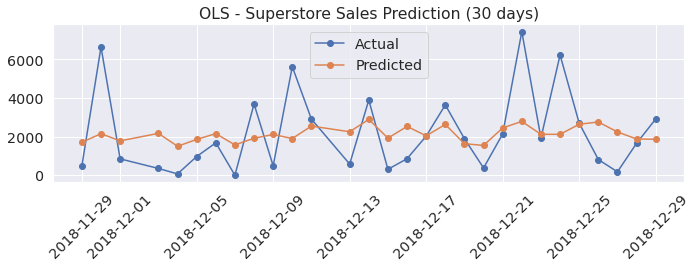

In [27]:
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(olsPred, label='Predicted', marker='o')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.title("OLS - Superstore Sales Prediction (30 days)")
plt.tight_layout()
plt.show()

Predicted values generally catch the trend of peaks and troughs; however, all the values are quite conservative hovering around 2000, which is the middle point of all actual values.

## SARIMA

In [29]:
print(sarimaModel.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4869      0.020    -23.857      0.000      -0.527      -0.447
ar.S.L25      -0.5030      0.020    -25.675      0.000      -0.541      -0.465
sigma2      1.366e+07   3.88e+05     35.173      0.000    1.29e+07    1.44e+07


In [30]:
print(sarimaModel.summary())

# get the predictions and residuals
sarimaPred = sarimaModel.forecast(len(dfTest))
sarimaPred.index = dfTest.index
mae = mean_absolute_error(sarimaPred, dfTest['Sales'])
mse = mean_squared_error(sarimaPred, dfTest['Sales'])
rmse = np.sqrt(mse)
print(f"\n*****MAE: {mae}")
print(f"\n*****RMSE: {rmse}")

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                 1200
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 25)   Log Likelihood              -11166.785
Date:                            Wed, 21 Sep 2022   AIC                          22339.569
Time:                                    18:43:16   BIC                          22354.774
Sample:                                         0   HQIC                         22345.303
                                           - 1200                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4869      0.020    -23.857      0.000      -0.527      -0.447
ar.S.L25      -0.5030      0.020   

/home/user/miniconda3/envs/AI/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


## RMSE

RMSE of the SARIMA model is 5987.911096.
- Тоа е просечно колку е вредноста на излезот.

### percentage error:
### rmpse = 6.455668609667536
### mape = 5.127976537011897

| Model | RMSE | MAE |
| --- | --- | --- |
| SARIMA | 5987.911096367575 | 5226.418626735905 |

### 30-Day Predictions


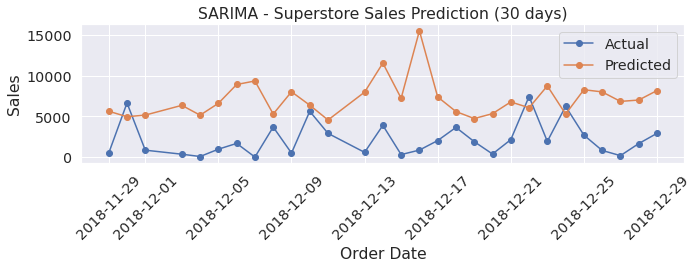

In [31]:
orderTime = dfTest.index
plt.figure(figsize=(10, 4))
plt.plot(orderTime, dfTest['Sales'], label="Actual", marker='o')
plt.plot(orderTime, sarimaPred, label="Predicted", marker='o')
plt.xticks(rotation=45)
plt.legend(loc = "best")
plt.xlabel("Order Date")
plt.ylabel("Sales")
plt.title("SARIMA - Superstore Sales Prediction (30 days)")
plt.tight_layout()
plt.show()

The predicted values were generally much higher than the actual values; however, it is doing a better job trailing the up and down trends.


## Stacked

In [32]:
# evaluate model on test set
yhat = stacked_prediction(olsModel, sarimaModel, stackedModel, X_test)
# convert array to series with a timeseries index
yhat = pd.Series(yhat)
yhat.index = y_test.index

mae = mean_absolute_error(y_test, yhat)
rmse = mean_squared_error(y_test, yhat, squared=False)
print('\n*****Stacked Test MAE: %.3f' % mae)
print('\n*****Stacked Test RMSE: %.3f' % rmse)


*****Stacked Test MAE: 1380.021

*****Stacked Test RMSE: 1748.224


/home/user/miniconda3/envs/AI/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


The stacked model generated the lowest RMSE - 1748.224.

## RMSE

The stacked model generated the lowest RMSE of 1748.224.


| Model | RMSE | MAE |
| --- | --- | --- |
| Stacked | 1748.224 | 1380.021 |

### 30-Day Predictions


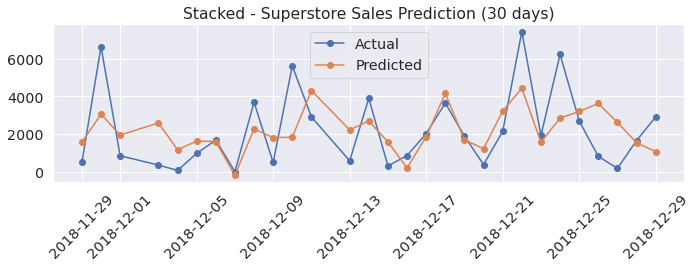

In [33]:
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(yhat, label='Predicted', marker='o')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.title("Stacked - Superstore Sales Prediction (30 days)")
plt.tight_layout()
plt.show()

It is apparent the stacked model produces the predictions that are the closest to the actual values.

## Model Comparison

The table below shows RMSE values of each model.

| Model | RMSE | MAE |
| --- | --- | --- |
| OLS | 38.66348468520611 | 1953.9729415373363 |
| SARIMA | 5987.911096367575 | 5226.418626735905 |
| Stacked | 1748.224 | 1380.021 |
| XGBoost |  2631.1136 | 1961.4080 |

The stacked model has the lowest RMSE value; therefore, it is our best model.

## Future Predictions

Using the selected best model, we can make a t+1 prediction from the most current observed data. The remaining 15-day of time steps were used here to validate the stacked model.


In [34]:
NUM_PREDICTION_DAY = 1

In [35]:
def addPredicitionDate(df, n):
    """
    Add the prediction date to the original dataset.
    :param df: dataset
    :param n: number of time step to shift front.
    :return: new dataset with t+n dates as index.
    """
    rowNum = df.shape[0]
    lastDate = df.index[rowNum-1]

    dateIndex = []
    for i in range(n) :
        tPlus1Date = lastDate + datetime.timedelta(days=1)
        dateIndex.append(tPlus1Date)
        lastDate = tPlus1Date

    dfForPrediction = dfDailySales.copy()

    for date in dateIndex:
        dfForPrediction.loc[date] = None

    return dfForPrediction

In [36]:
# add t+1 date to the original dataset
dfTPlus1 = addPredicitionDate(dfSales, NUM_PREDICTION_DAY)
dfTPlus1Prepared = prepareDf(dfTPlus1, ["Sales"])

# preprocess future data to put it into stacked model.
futureX = dfTPlus1Prepared.iloc[-NUM_PREDICTION_DAY].to_frame().T
futureX = futureX[sigFeaturesLi]
futureX = sm.add_constant(futureX, has_constant='add')

In [37]:
# predict
validationPred = stacked_prediction(olsModel, sarimaModel, stackedModel, stack_X_test)
futurePred = stacked_prediction(olsModel, sarimaModel, stackedModel, futureX)
# convert array to series with a timeseries index
validationPred = pd.Series(validationPred)
validationPred.index = stack_y_test.index
print(f"\n*****\tRMSE of the validation set is {mean_squared_error(stack_y_test, validationPred, squared=False)}")
print(f"\n*****\tMAE of the validation set is {mean_absolute_error(stack_y_test, validationPred)}")

futurePred = pd.Series(futurePred)
futurePred.index = futureX.index
validationPred = pd.concat([validationPred, futurePred])

print(f"\n*****\tSales prediction for {futurePred.index[0]} is {futurePred.values[0]}")


*****	RMSE of the validation set is 1053.6887592908201

*****	MAE of the validation set is 1053.6887592908201

*****	Sales prediction for 2018-12-31 00:00:00 is 3076.065094031933


/home/user/miniconda3/envs/AI/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/user/miniconda3/envs/AI/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


## Final Prediction

RMSE of the stacked model is 2262.48

The most recent observed order date in the dataset is 2018-12-30; therefore, our t+1 is the next day, which is 2018-12-31. Superstore's sales on 2018-12-31 was predicted to 3066.71.

See below for the visual representation of the validation prediction and the future prediction.


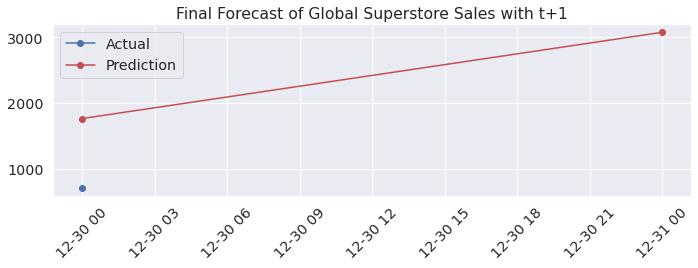

In [38]:
# plot forecast along with 15 day validation data
indexForecast = pd.date_range(dfDailySales.index[-EVAL_DAYS], periods=EVAL_DAYS + 1, freq = 'D')
actualSeries = pd.Series(stack_y_test, index=indexForecast)
validationSeries = pd.Series(validationPred, index=indexForecast)

plt.figure(figsize=(10, 4))
plt.plot(actualSeries, color="b", label="Actual", marker='o')
plt.plot(validationSeries, color="r", label="Prediction", marker='o')
plt.title("Final Forecast of Global Superstore Sales with t+1")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# XGBoost


In [39]:
import xgboost as xgb
color_pal = sns.color_palette()

In [40]:
dfDailySales.head()

,Sales
Order Date,
2015-01-02,468.900
2015-01-03,2203.151
2015-01-04,119.888
2015-01-06,5188.520
2015-01-07,601.024


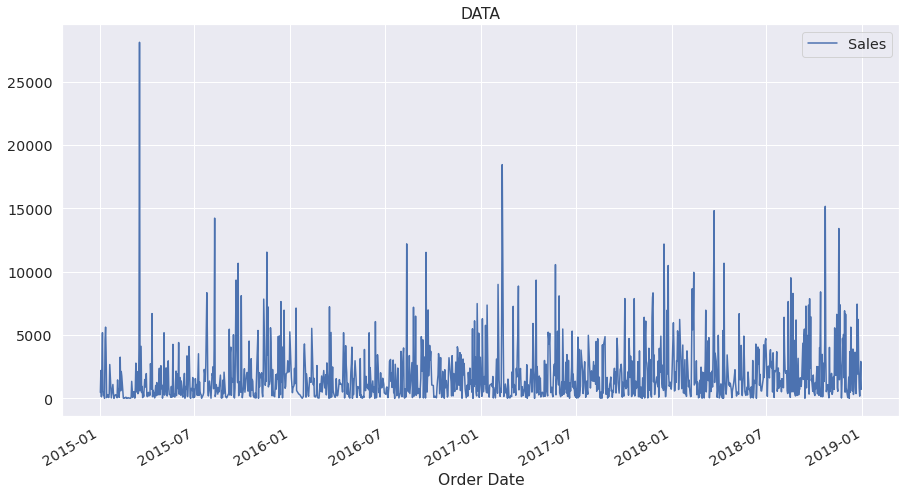

In [41]:
a = dfDailySales.plot(style='-',
                 figsize=(15,8),
                 color=color_pal[0],
                 title='DATA')
plt.show()

<AxesSubplot:ylabel='Frequency'>

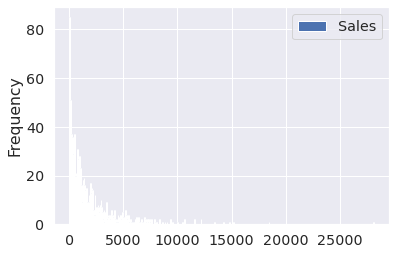

In [42]:
dfDailySales.plot(kind='hist', bins=500)

# Time Series Cross Validation

In [43]:
from sklearn.model_selection import TimeSeriesSplit

In [44]:
tss = TimeSeriesSplit(n_splits=5, test_size=30, gap=1)
dfDailySales = dfDailySales.sort_index()

# n_splits = 5 -> we will loop over this 5 times.
# test_size = nasiot dataset e so denovi, taka sto sakame 30 dena nanapred da predvidime. (90 e sega - 3 meseci)
# gap = the gap between the training and validation that you're splitting each time.
# gap = 1 -> is 1 day between the training set ends and the test set begins.

# we have 30 days of validation set each fold.

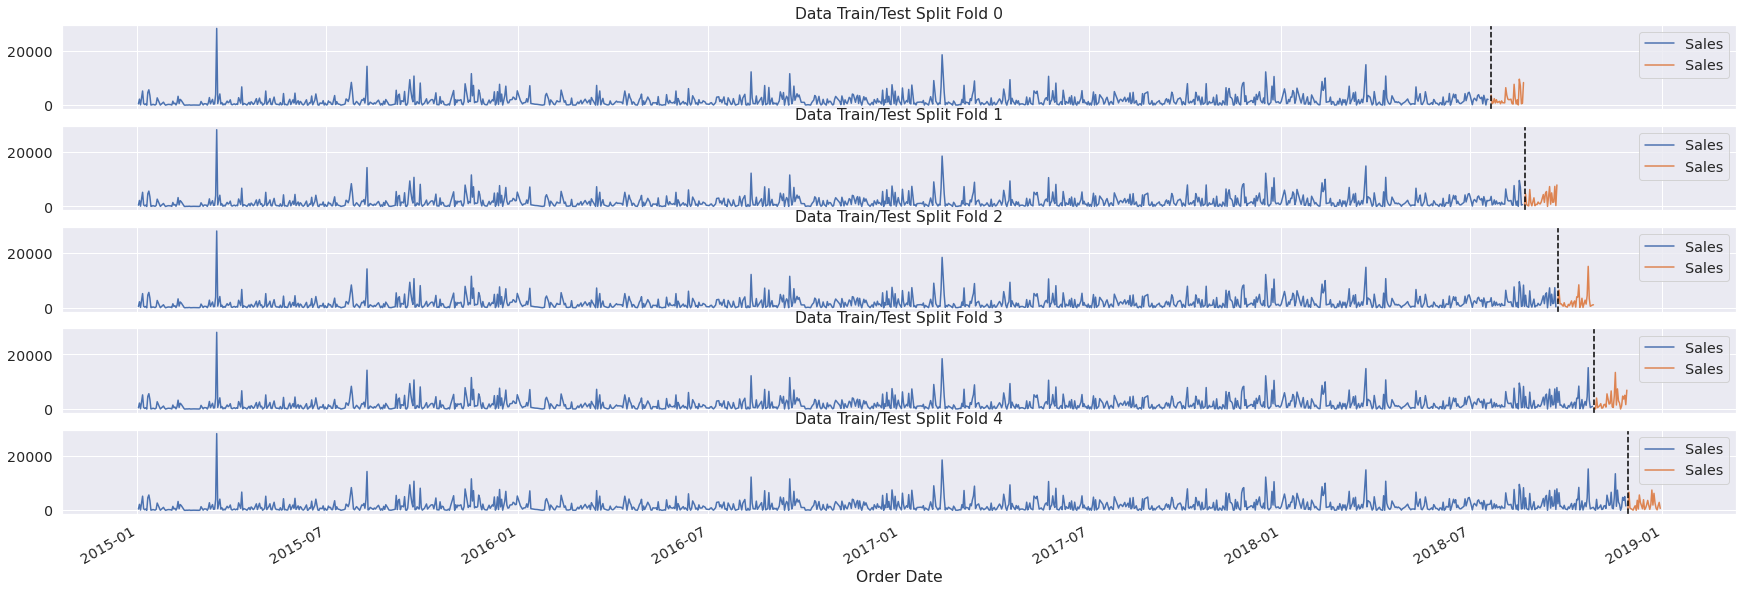

In [45]:
fig, axs = plt.subplots(5, 1, figsize=(30,10), sharex=True)
fold = 0

for train_idx, val_idx in tss.split(dfDailySales):
    train = dfDailySales.iloc[train_idx]
    test = dfDailySales.iloc[val_idx]
    train.plot(ax=axs[fold],
               label="Training Set",
               title=f'Data Train/Test Split Fold {fold}')
    test.plot(ax=axs[fold],
              label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# Forecasting Horizon
how long in the future you want to predict

In [46]:
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(dfDailySales)

# Train the Data

In [92]:
tss = TimeSeriesSplit(n_splits=5, test_size=30, gap=1)
dfDailySales = dfDailySales.sort_index()

fold = 0
preds = []
scores = []
scores2 = []
for train_idx, val_idx in tss.split(dfDailySales):
    train = dfDailySales.iloc[train_idx]
    test = dfDailySales.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)
    
    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
    TARGET = 'Sales'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.6, booster='gbtree',
                          n_estimators=1000,
                          early_stopping_rounds=50,
                          objective='reg:linear',
                          max_depth=9,
                          learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    fold+=1
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    score2 = mean_absolute_error(y_test, y_pred)
    scores.append(score)
    scores2.append(score2)

[19:18:40] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[19:18:40] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:2815.91894	validation_1-rmse:3554.13867
[100]	validation_0-rmse:1804.76453	validation_1-rmse:2842.41504
[200]	validation_0-rmse:1366.81787	validation_1-rmse:2656.60254
[300]	validation_0-rmse:1118.64673	validation_1-rmse:2594.77686
[400]	validation_0-rmse:951.18903	validation_1-rmse:2561.67358
[500]	validation_0-rmse:829.67053	validation_1-rmse:2577.13623
[

In [93]:
# 5 pati se izvrsuva, zaradi Cross-validation. I sega scores od 5-te iteracii mozime da dobieme:
print(f'Score across folds (RMSE) {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')
print(f'Score across folds (MAE) {np.mean(scores2):0.4f}')
print(f'Fold scores:{scores2}')

Score across folds (RMSE) 2953.3923
Fold scores:[2607.156203519604, 3094.889455330828, 3501.1225251500164, 3729.9417516196813, 1833.8517985718004]
Score across folds (MAE) 1952.8928
Fold scores:[1829.6070329915362, 2186.962860681152, 1987.5935696788538, 2374.710357552083, 1385.5900331152343]


### RMSE and MAE

| Model | RMSE | MAE |
| --- | --- | --- |
| XGBoost | 2953.3923 | 1952.8928 |

### Hyperparameters for the XGBoost model 

| Hyperparameter | Final Value |
| --- | --- |
| Subsample ratio of columns when constructing each tree | 0.9 |
| Learning rate | 0.1 |
| Max depth | 3 |
| Number of splits | 5 |
| Number of estimators | 1000 |

In [94]:
np.median(scores)

3094.889455330828

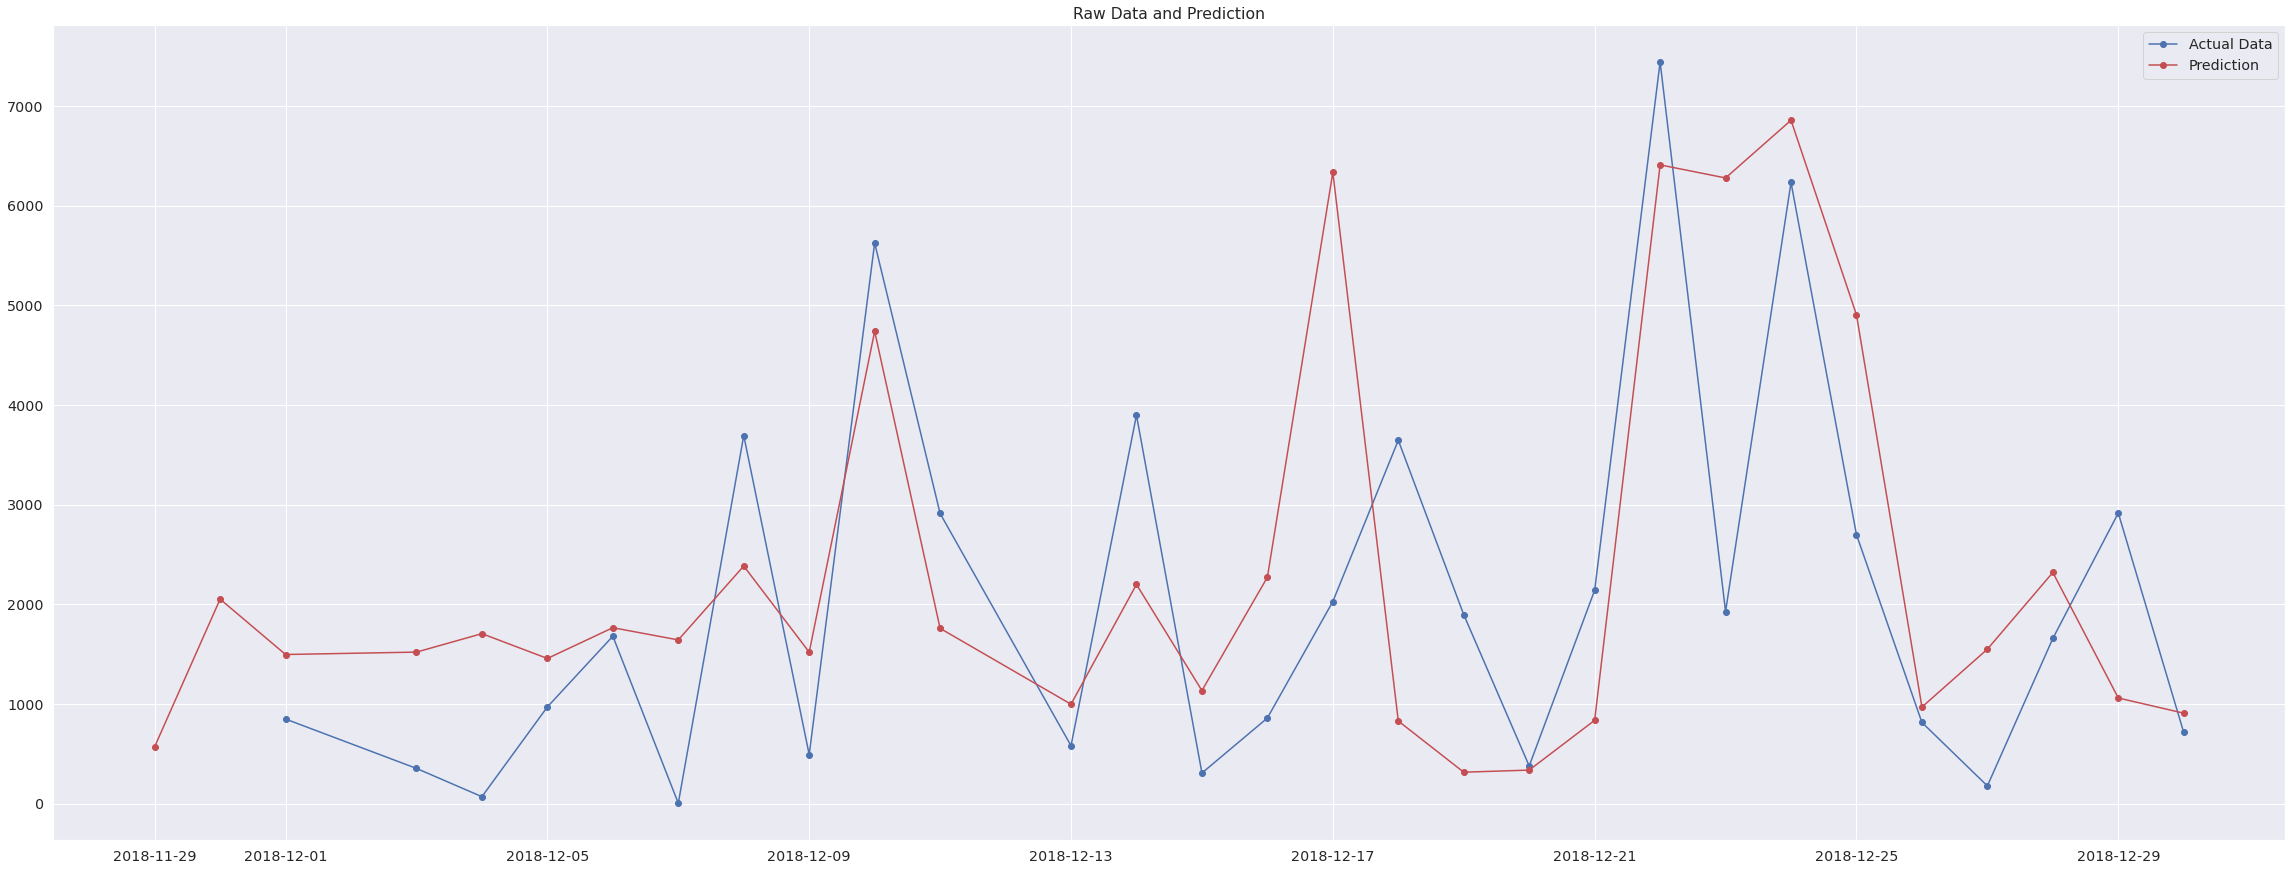

In [95]:
test['prediction'] = y_pred
a = dfDailySales['2018-12-01':'2019-01-01']
plt.figure(figsize=(40, 15))
plt.plot(a[['Sales']], color="b", label="Actual Data", marker='o')
plt.plot(test[['prediction']], color="r", label="Prediction", marker='o')
plt.title("Raw Data and Prediction")
plt.legend()
plt.show()

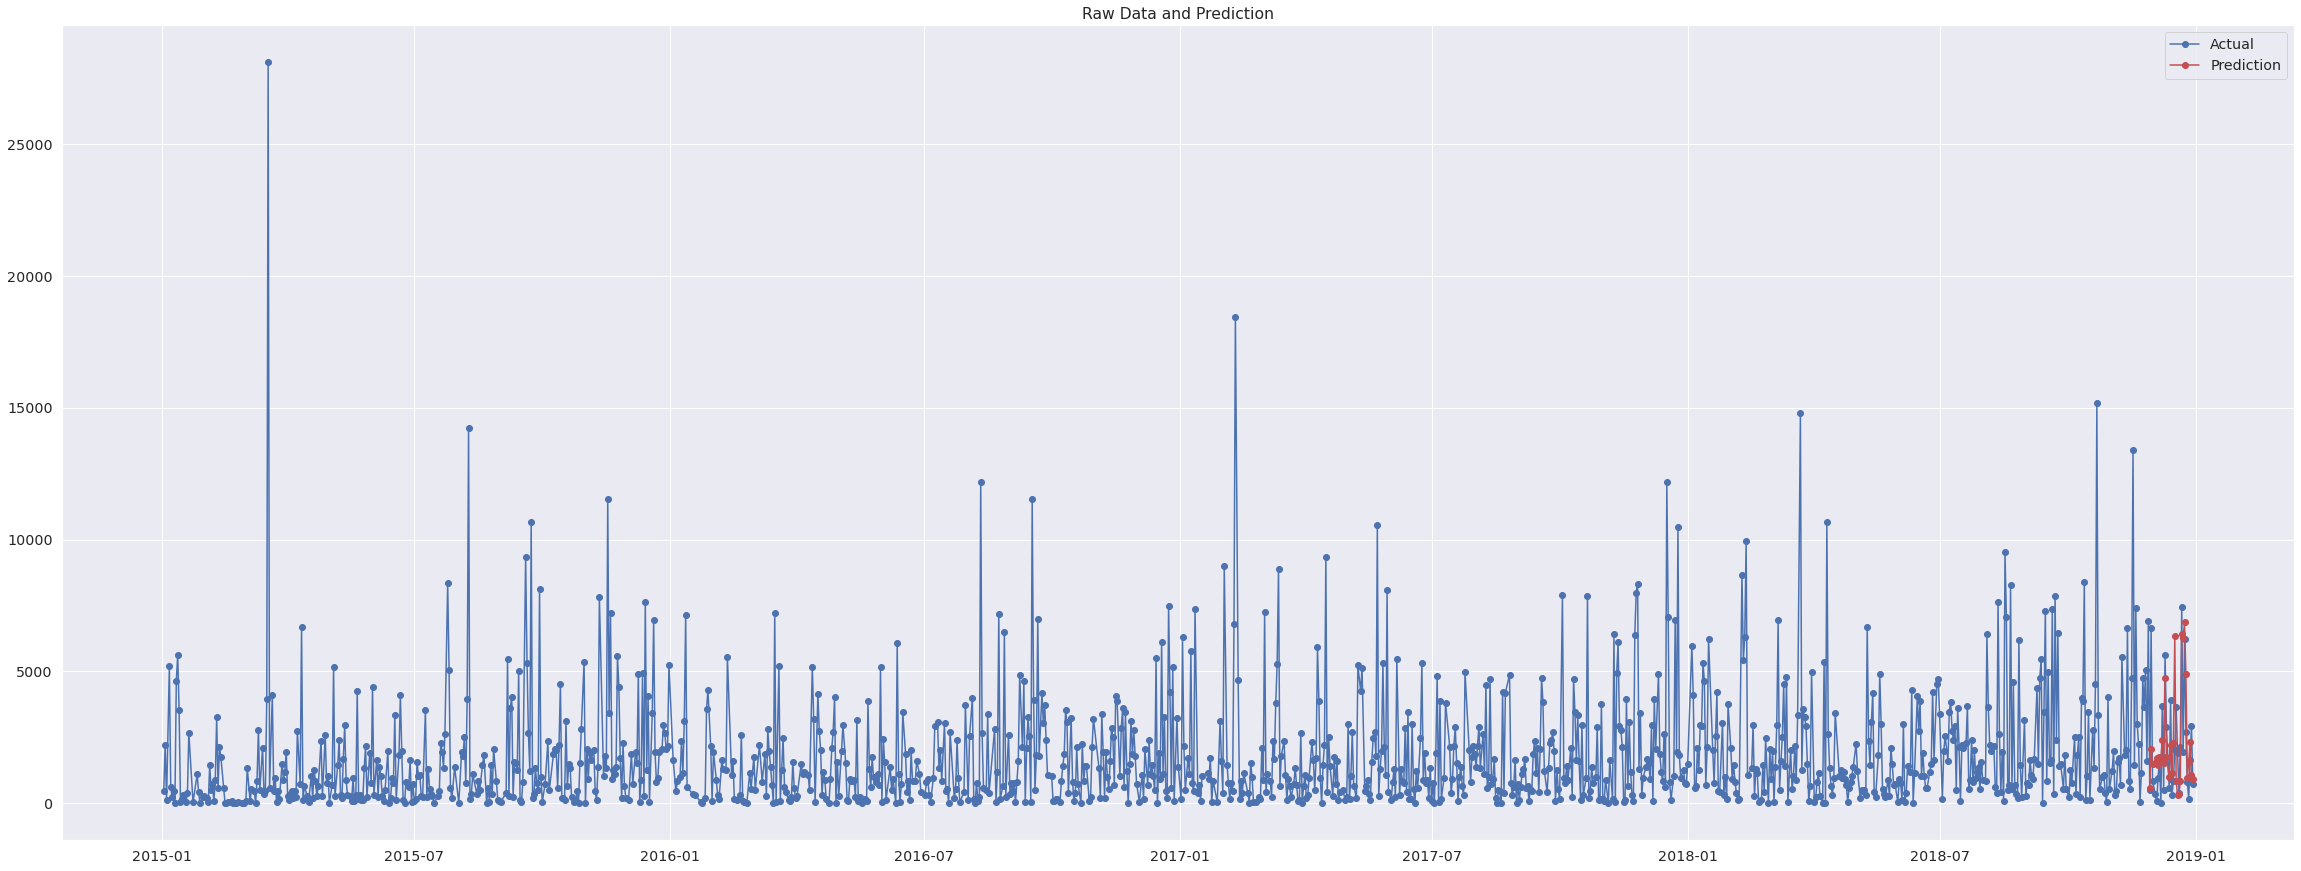

In [87]:
test['prediction'] = y_pred
plt.figure(figsize=(40, 15))
plt.plot(dfDailySales['Sales'], color="b", label="Actual", marker='o')
plt.plot(test[['prediction']], color="r", label="Prediction", marker='o')
plt.title("Raw Data and Prediction")
plt.legend()
plt.show()

# Conclusion

I think it was a good challenge to work with data that portraits high seasonality. However, it was a bit tricky because there were multiple rows that have the same order date. Aggregating and summing all the sales up for the same order date made all the other columns useless that could potentially become other predictor variables.

If I have time to improve my model further, I would like to see if I can combine it with some external data such as covid cases, other supermarket's sales and weather. Superstore is a place where people go regularly to shop necessities. I think their sales data may get influenced a lot by environmental changes or socioeconomic issues.
